In [25]:
import pandas as pd
import time
import re

#### 데이터 불러오기 (pos 및 특수문자 등 정제된 데이터임. 정제 방법은 깃허브 코드 참고)
#### https://github.com/Ryleyun91/Ryles_Practice/tree/main/DACON
train = pd.read_csv('../DATA/train_data.csv')
test = pd.read_csv('../DATA/test_data.csv')

In [26]:
### 데이터 불러오기 (정제 안 된 것)
train = pd.read_csv("../DATA/open/train.csv")
test = pd.read_csv("../DATA/open/test.csv")

from konlpy.tag import Mecab
mecab = Mecab()

In [27]:
%%time
def pos(x):
    try:
        text = ''
        for word, pos in mecab.pos(str(x)):
            if pos[0] not in ['J','I','E']:
                if type(re.search("\W+|[0-9]", word))!=re.Match: 
                    # and len(word)!=1:
                    text+=" "+word
        return text.strip()
    
    except:
        pass


train["과제명"] = train["과제명"].apply(pos)
train["요약문_연구목표"] = train["요약문_연구목표"].apply(pos)
train["요약문_연구내용"] = train["요약문_연구내용"].apply(pos)
train["요약문_기대효과"] = train["요약문_기대효과"].apply(pos)
train["요약문_한글키워드"] = train["요약문_한글키워드"].apply(pos)

test["과제명"] = test["과제명"].apply(pos)
test["요약문_연구목표"] = test["요약문_연구목표"].apply(pos)
test["요약문_연구내용"] = test["요약문_연구내용"].apply(pos)
test["요약문_기대효과"] = test["요약문_기대효과"].apply(pos)
test["요약문_한글키워드"] = test["요약문_한글키워드"].apply(pos)

CPU times: user 6min 31s, sys: 852 ms, total: 6min 32s
Wall time: 6min 33s


In [53]:
train_name_key = [str(sent) for sent in train['과제명'] + " " + train['요약문_한글키워드']]
train_goal = [str(sent) for sent in train['요약문_연구목표']]
train_cont = [str(sent) for sent in train['요약문_연구내용']]
train_effect = [str(sent) for sent in train['요약문_기대효과']]
test_name_key = [str(sent) for sent in test['과제명'] + " " + test['요약문_한글키워드']]
test_goal = [str(sent) for sent in test['요약문_연구목표']]
test_cont = [str(sent) for sent in test['요약문_연구내용']]
test_effect = [str(sent) for sent in test['요약문_기대효과']]
train_label = [int(str(answer)) for answer in train['label']]

In [29]:
# EDA
train_name_key_len = [len(str(sent)) for sent in train_name_key]
train_goal_len = [len(str(sent)) for sent in train_goal]
train_cont_len = [len(str(sent)) for sent in train_cont]
train_effect_len = [len(str(sent)) for sent in train_effect]
test_name_key_len = [len(str(sent)) for sent in test_name_key]
test_goal_len = [len(str(sent)) for sent in test_goal]
test_cont_len = [len(str(sent)) for sent in test_cont]
test_effect_len = [len(str(sent)) for sent in test_effect]

(array([2.7710e+03, 1.9776e+04, 1.6789e+04, 3.8300e+03, 3.5200e+02,
        4.6000e+01, 8.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  7. ,  39.3,  71.6, 103.9, 136.2, 168.5, 200.8, 233.1, 265.4,
        297.7, 330. ]),
 <BarContainer object of 10 artists>)

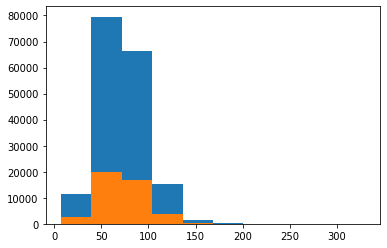

In [31]:
# name_key
import matplotlib.pyplot as plt
plt.hist(train_name_key_len)
plt.hist(test_name_key_len)

## max_len 140정도 주면 커버될 듯

(array([3.2474e+04, 9.0970e+03, 1.5480e+03, 3.1900e+02, 9.6000e+01,
        3.6000e+01, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0.,  373.,  746., 1119., 1492., 1865., 2238., 2611., 2984.,
        3357., 3730.]),
 <BarContainer object of 10 artists>)

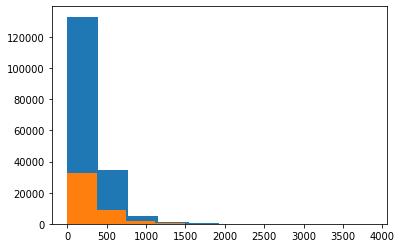

In [32]:
# goal
plt.hist(train_goal_len)
plt.hist(test_goal_len)

## max_len 800정도 주면 커버될 듯

(array([1.4038e+04, 1.4856e+04, 8.2060e+03, 4.2230e+03, 1.6940e+03,
        4.5800e+02, 8.1000e+01, 1.0000e+01, 3.0000e+00, 7.0000e+00]),
 array([   0. ,  354.7,  709.4, 1064.1, 1418.8, 1773.5, 2128.2, 2482.9,
        2837.6, 3192.3, 3547. ]),
 <BarContainer object of 10 artists>)

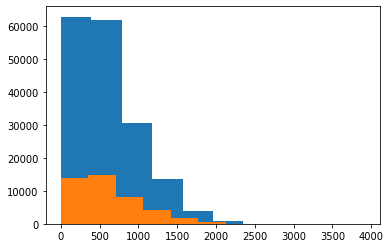

In [33]:
# cont
plt.hist(train_cont_len)
plt.hist(test_cont_len)

## max_len 1500정도 주면 커버될 듯

(array([1.9092e+04, 1.6035e+04, 5.9950e+03, 1.4320e+03, 5.8900e+02,
        2.6500e+02, 8.6000e+01, 6.5000e+01, 1.5000e+01, 2.0000e+00]),
 array([   0.,  264.,  528.,  792., 1056., 1320., 1584., 1848., 2112.,
        2376., 2640.]),
 <BarContainer object of 10 artists>)

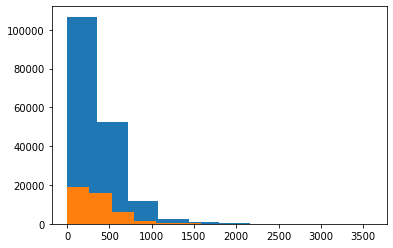

In [34]:
# effect
plt.hist(train_effect_len)
plt.hist(test_effect_len)

## max_len 1000정도 주면 커버될 듯

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras import layers, models
import numpy as np

In [61]:
def CNN(train_data, test_data, maxlen, embedding):
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    tokenizer = Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(train_data)
    word_index = tokenizer.word_index
    train_seq = tokenizer.texts_to_sequences(train_data)
    test_seq = tokenizer.texts_to_sequences(test_data)
    train_pad = pad_sequences(train_seq, maxlen=maxlen, padding='post', truncating='post')
    test_pad = pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')
    
    vocab_size = len(word_index)+1
    
    model = Sequential()
    # Embedding layer? Input 값이 처음으로 들어오는 layer
    # vocab_size는 데이터 셋 내의 유니크 단어 수, embedding_dim은 몇 차원으로 줄일 것인지, input_length는 들어오는 문장의 최대 길이
    model.add(Embedding(vocab_size, embedding, input_length=maxlen))
    model.add(layers.Conv1D(32, 5, activation='relu', padding='Same'))
    model.add(Dropout(0.5))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 2, activation='relu', padding='Same'))
    model.add(Dropout(0.5))
    model.add(layers.MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(46, activation='softmax'))

    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model, train_pad, test_pad

In [62]:
model, train_pad, test_pad = CNN(train_name_key, test_name_key, 140, 100)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 140, 100)          5642200   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 140, 32)           16032     
_________________________________________________________________
dropout_30 (Dropout)         (None, 140, 32)           0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 70, 32)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 70, 64)            4160      
_________________________________________________________________
dropout_31 (Dropout)         (None, 70, 64)            0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 35, 64)           

In [64]:
model.fit(train_pad, np.array(train_label), epochs=20, batch_size=1000, validation_split=0.2, verbose=2)

Epoch 1/20
140/140 - 29s - loss: 0.6652 - accuracy: 0.8292 - val_loss: 0.7949 - val_accuracy: 0.8212
Epoch 2/20
140/140 - 30s - loss: 0.5952 - accuracy: 0.8334 - val_loss: 0.7188 - val_accuracy: 0.8257
Epoch 3/20
140/140 - 29s - loss: 0.5327 - accuracy: 0.8426 - val_loss: 0.6765 - val_accuracy: 0.8296
Epoch 4/20
140/140 - 30s - loss: 0.4816 - accuracy: 0.8554 - val_loss: 0.6521 - val_accuracy: 0.8450
Epoch 5/20
140/140 - 29s - loss: 0.4374 - accuracy: 0.8680 - val_loss: 0.6415 - val_accuracy: 0.8436
Epoch 6/20
140/140 - 30s - loss: 0.4036 - accuracy: 0.8788 - val_loss: 0.6274 - val_accuracy: 0.8508
Epoch 7/20
140/140 - 28s - loss: 0.3723 - accuracy: 0.8893 - val_loss: 0.6398 - val_accuracy: 0.8608
Epoch 8/20
140/140 - 28s - loss: 0.3459 - accuracy: 0.8976 - val_loss: 0.6299 - val_accuracy: 0.8607
Epoch 9/20
140/140 - 29s - loss: 0.3262 - accuracy: 0.9042 - val_loss: 0.6574 - val_accuracy: 0.8705
Epoch 10/20
140/140 - 29s - loss: 0.3064 - accuracy: 0.9097 - val_loss: 0.6187 - val_accura

In [65]:
# 모델 예측
name_key_answer = model.predict(test_pad)

In [66]:
CNN(train_goal, test_goal, 800, 200)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 800, 200)          20462400  
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 800, 32)           32032     
_________________________________________________________________
dropout_35 (Dropout)         (None, 800, 32)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 400, 32)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 400, 64)           4160      
_________________________________________________________________
dropout_36 (Dropout)         (None, 400, 64)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 200, 64)          

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f9ca1a37580>,
 array([[   77,  2329,  4534, ...,     0,     0,     0],
        [  603,   509,  8930, ...,     0,     0,     0],
        [33103,   281,  7611, ...,     0,     0,     0],
        ...,
        [ 2480,    97,  1873, ...,     0,     0,     0],
        [49838,     3, 13713, ...,     0,     0,     0],
        [   25,     7,   246, ...,     0,     0,     0]], dtype=int32),
 array([[  3820,  35748,  48452, ...,      0,      0,      0],
        [   775,    184,    452, ...,      0,      0,      0],
        [   404,  27208,   7725, ...,      0,      0,      0],
        ...,
        [ 10738,  17363,  20717, ...,      0,      0,      0],
        [    25,      7,    324, ...,      0,      0,      0],
        [100102,    286,   6748, ...,      0,      0,      0]], dtype=int32))

In [67]:
model.fit(train_pad, np.array(train_label), epochs=20, batch_size=1000, validation_split=0.2, verbose=2)

Epoch 1/20
140/140 - 28s - loss: 0.1946 - accuracy: 0.9421 - val_loss: 0.7126 - val_accuracy: 0.8865
Epoch 2/20
140/140 - 28s - loss: 0.1906 - accuracy: 0.9425 - val_loss: 0.7480 - val_accuracy: 0.8853
Epoch 3/20
140/140 - 28s - loss: 0.1865 - accuracy: 0.9436 - val_loss: 0.7643 - val_accuracy: 0.8873
Epoch 4/20
140/140 - 29s - loss: 0.1801 - accuracy: 0.9463 - val_loss: 0.7715 - val_accuracy: 0.8880
Epoch 5/20
140/140 - 28s - loss: 0.1772 - accuracy: 0.9471 - val_loss: 0.7165 - val_accuracy: 0.8916
Epoch 6/20
140/140 - 28s - loss: 0.1722 - accuracy: 0.9478 - val_loss: 0.7576 - val_accuracy: 0.8931
Epoch 7/20
140/140 - 28s - loss: 0.1694 - accuracy: 0.9491 - val_loss: 0.7331 - val_accuracy: 0.8920
Epoch 8/20
140/140 - 28s - loss: 0.1625 - accuracy: 0.9508 - val_loss: 0.7315 - val_accuracy: 0.8902
Epoch 9/20
140/140 - 28s - loss: 0.1611 - accuracy: 0.9512 - val_loss: 0.7635 - val_accuracy: 0.8931
Epoch 10/20
140/140 - 28s - loss: 0.1595 - accuracy: 0.9518 - val_loss: 0.7545 - val_accura

In [68]:
goal_answer = model.predict(test_pad)

In [69]:
CNN(train_cont, test_cont, 1500, 200)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1500, 200)         30442600  
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1500, 32)          32032     
_________________________________________________________________
dropout_40 (Dropout)         (None, 1500, 32)          0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 750, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 750, 64)           4160      
_________________________________________________________________
dropout_41 (Dropout)         (None, 750, 64)           0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 375, 64)          

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f9c81594730>,
 array([[ 3956,     2, 28769, ...,     0,     0,     0],
        [   33,  2485,    29, ...,     0,     0,     0],
        [35909,   358,  7771, ...,     0,     0,     0],
        ...,
        [ 1702,    12,   555, ...,     0,     0,     0],
        [   83,    95, 47895, ...,     0,     0,     0],
        [   33,     7,     4, ...,     0,     0,     0]], dtype=int32),
 array([[   33,     4,  5608, ...,     0,     0,     0],
        [    7,   168,  5536, ...,     0,     0,     0],
        [   67,     7,  9098, ...,     0,     0,     0],
        ...,
        [10968,  9131, 11733, ...,     0,     0,     0],
        [   67,  2086,     7, ...,     0,     0,     0],
        [    1,  3373,  1158, ...,     0,     0,     0]], dtype=int32))

In [70]:
model.fit(train_pad, np.array(train_label), epochs=20, batch_size=1000, validation_split=0.2, verbose=2)

Epoch 1/20
140/140 - 28s - loss: 0.1296 - accuracy: 0.9608 - val_loss: 0.8087 - val_accuracy: 0.8993
Epoch 2/20
140/140 - 28s - loss: 0.1298 - accuracy: 0.9613 - val_loss: 0.8301 - val_accuracy: 0.8991
Epoch 3/20
140/140 - 28s - loss: 0.1276 - accuracy: 0.9618 - val_loss: 0.8499 - val_accuracy: 0.9015
Epoch 4/20
140/140 - 28s - loss: 0.1230 - accuracy: 0.9632 - val_loss: 0.8873 - val_accuracy: 0.9013
Epoch 5/20
140/140 - 28s - loss: 0.1212 - accuracy: 0.9641 - val_loss: 0.8934 - val_accuracy: 0.9018
Epoch 6/20
140/140 - 28s - loss: 0.1211 - accuracy: 0.9635 - val_loss: 0.8741 - val_accuracy: 0.9008
Epoch 7/20
140/140 - 28s - loss: 0.1210 - accuracy: 0.9639 - val_loss: 0.8379 - val_accuracy: 0.9007
Epoch 8/20
140/140 - 28s - loss: 0.1184 - accuracy: 0.9644 - val_loss: 0.8611 - val_accuracy: 0.9034
Epoch 9/20
140/140 - 28s - loss: 0.1166 - accuracy: 0.9650 - val_loss: 0.8746 - val_accuracy: 0.9028
Epoch 10/20
140/140 - 28s - loss: 0.1160 - accuracy: 0.9654 - val_loss: 0.8881 - val_accura

In [71]:
cont_answer = model.predict(test_pad)

In [72]:
CNN(train_effect, test_effect, 1000, 200)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 200)         18577400  
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1000, 32)          32032     
_________________________________________________________________
dropout_45 (Dropout)         (None, 1000, 32)          0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 500, 32)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 500, 64)           4160      
_________________________________________________________________
dropout_46 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 250, 64)          

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f9cc3e25040>,
 array([[   44,  4330,     4, ...,     0,     0,     0],
        [ 9116,   723,   532, ...,     0,     0,     0],
        [   34,   870,     3, ...,     0,     0,     0],
        ...,
        [   27,    83,     8, ...,     0,     0,     0],
        [13888,     4, 16346, ...,     0,     0,     0],
        [   27,    11,    26, ...,     0,     0,     0]], dtype=int32),
 array([[   6,    3,  251, ...,    0,    0,    0],
        [  27,   11, 1545, ...,    0,    0,    0],
        [  27,   11,  437, ...,    0,    0,    0],
        ...,
        [   6,    3,   49, ...,    0,    0,    0],
        [1656,  495, 6368, ...,    0,    0,    0],
        [   1,  134, 1163, ...,    0,    0,    0]], dtype=int32))

In [73]:
model.fit(train_pad, np.array(train_label), epochs=20, batch_size=1000, validation_split=0.2, verbose=2)

Epoch 1/20
140/140 - 29s - loss: 0.1023 - accuracy: 0.9700 - val_loss: 0.8912 - val_accuracy: 0.9050
Epoch 2/20
140/140 - 29s - loss: 0.1018 - accuracy: 0.9701 - val_loss: 0.9548 - val_accuracy: 0.9061
Epoch 3/20
140/140 - 29s - loss: 0.0997 - accuracy: 0.9709 - val_loss: 0.9591 - val_accuracy: 0.9043
Epoch 4/20
140/140 - 29s - loss: 0.0987 - accuracy: 0.9708 - val_loss: 0.9415 - val_accuracy: 0.9045
Epoch 5/20
140/140 - 29s - loss: 0.0978 - accuracy: 0.9713 - val_loss: 0.9321 - val_accuracy: 0.9065
Epoch 6/20
140/140 - 29s - loss: 0.0971 - accuracy: 0.9716 - val_loss: 0.9792 - val_accuracy: 0.9061
Epoch 7/20
140/140 - 29s - loss: 0.0954 - accuracy: 0.9719 - val_loss: 1.0407 - val_accuracy: 0.9082
Epoch 8/20
140/140 - 29s - loss: 0.0932 - accuracy: 0.9722 - val_loss: 0.9327 - val_accuracy: 0.9049
Epoch 9/20
140/140 - 30s - loss: 0.0936 - accuracy: 0.9722 - val_loss: 1.0467 - val_accuracy: 0.9076
Epoch 10/20
140/140 - 29s - loss: 0.0944 - accuracy: 0.9721 - val_loss: 0.9661 - val_accura

In [76]:
effect_answer = model.predict(test_pad)

In [77]:
answer = (name_key_answer + goal_answer + cont_answer + effect_answer)/4

# tokenizing

tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index

# padding

train_seq = tokenizer.texts_to_sequences(train_data)
test_seq = tokenizer.texts_to_sequences(test_data)
train_pad = pad_sequences(train_seq, maxlen=100, padding='post', truncating='post')
test_pad = pad_sequences(test_seq, maxlen=100, padding='post', truncating='post')

model = Sequential()
# Embedding layer? Input 값이 처음으로 들어오는 layer
# vocab_size는 데이터 셋 내의 유니크 단어 수, embedding_dim은 몇 차원으로 줄일 것인지, input_length는 들어오는 문장의 최대 길이
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(32, 5, activation='relu', padding='Same'))
model.add(Dropout(0.5))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 2, activation='relu', padding='Same'))
model.add(Dropout(0.5))
model.add(layers.MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_pad, train_label, epochs=25, batch_size=1000, validation_split=0.1, verbose=2)

In [79]:
# 모델 예측
import tensorflow as tf
pred = tf.argmax(answer, axis=1)

In [84]:
sample_submission=pd.read_csv('../DATA/open/sample_submission.csv')
sample_submission['label']=pred
sample_submission.to_csv('../DATA/Result/CNN_voting.csv', index=False)